# 0. はじめに

物理学の実験においては、事前に測定値を予測することが可能な様々な理論式が知られています。理論式を検証するために実験を行うこともあれば、理論式に合わない実験結果を説明するために新たな理論が提唱されることもあります。ここではラザフォード散乱の式を例にとり、理論式を用いた予想と検証を行います。ラザフォード散乱による散乱事象の数$N_{exp}$は

$$
N_{exp}=B⋅t⋅N\frac{dσ}{d\Omega}(θ,ϕ)\cdotΔΩ
$$

と推測されます。$B$は単位時間に標的に入射するアルファ線数、$t$は測定時間、$N$は薄膜の単位面積あたりに存在する原子数、$dσ/d\Omega$は単位立体角当たりのラザフォード散乱の確率、$ΔΩ$はセンサーの見込み角です。これら推測に必要な各種パラメタを測定し、具体的な事象数の推測をこのノートでは目指します。

このノートでは、実験前から結果を予想して議論するために、ダミーのデータを生成できるようになっています。データを取得したら置き換えることで、実際のデータに即した議論ができます。

pythonやjupyter notebookの基本的な使い方に関しては、内田誠氏作成の[こちらのノートブック](https://github.com/ktodome/b3exp/blob/master/notebooks/01_python_basics.ipynb)などを参考にしてください。

まずは以下のセルを実行して、本ノートブックの操作に必要な設定を行います。0.3.を実行することでダミーデータが生成されますが、こちらはその後のセルで実験データを読み込むと順次実データで上書きされて処理されます。

In [1]:
# @title 0.1. 必要設定の読み込み

#スクリプト実行に必要なパッケージ。
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import poisson,norm

#用いる関数を定義
def sig(x, a, m, s):#ガウシアン
    return a*np.exp(-0.5*(x-m)**2/s**2)

def lin(x,a,b):
    return a*x+b

def dlin(x,a,b,dx,da,db):#直線フィッティングの誤差導出用関数
    dy=(x*da)**2
    dy+=(dx*a)**2
    dy+=db**2
    dy=np.sqrt(dy)
    #print("{:10.4f}, {:10.4f}, {:10.4f}".format((x*da),dx*a,db))
    return dy
def pathToTime(path):
    time_format='"%Y-%m-%d" "%H:%M:%S"'
    temp = np.genfromtxt(path, skip_header=1025,skip_footer=1,dtype=str)
    start_text=temp[0]+' '+temp[1]
    start_time=datetime.datetime.strptime(start_text, time_format)
    end_text=temp[2]+' '+temp[3]
    end_time=datetime.datetime.strptime(end_text, time_format)
    Time=(end_time-start_time).seconds
    return Time

In [7]:
# @title 0.2. Googleドライブのマウント(オプション)

#実験データなど、Googleドライブにあるファイルにアクセスしたい場合に実行する。自分のアカウントで要認証。ダミーデータで取り組む場合は実行不要
from google.colab import drive
drive.mount('/content/drive')

#ファイルを格納するディレクトリを指定、要編集
basePath='/content/drive/MyDrive/temp/b3exp/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# @title 0.2. シミュレーションデータ生成

pulse_list=np.empty((0,1024),int)
hight=[]

A=723 #仮の中心値
dA=3 #仮の幅
off=5 #仮のオフセット
for scaling in [0.2,0.4,0.6,0.8,1.0]:
    y = np.random.normal(A*scaling+off, dA, 5000)#ガウス分布に従うイベントを5000個作る
    y, x = np.histogram(y, range=(0, 1024), bins=1024)#MCAの出力の形式（ヒストグラム）に変換する。以下中心のチャンネルを変えて繰り返し
    y=[y]
    pulse_list=np.append(pulse_list,y,axis=0)
    hight=np.append(hight,4.5*scaling)

Ealpha=800 #仮の中心値
dEalpha=25 #仮の幅

alpha_calib = np.random.normal(Ealpha, dEalpha, 5000)
alpha_calib, x = np.histogram(alpha_calib, range=(0, 1024), bins=1024)
Tcalib=20

EAu=668 #仮の値
dEAu=25 #シミュレーション用
EAl=222 #仮の値
dEAl=50 #シミュレーション用

Aldeg0 = np.random.normal(EAl, dEAl, 5000)
Aldeg0, x = np.histogram(Aldeg0, range=(0, 1024), bins=1024)
Audeg0 = np.random.normal(EAu, dEAu, 5000)
Audeg0, x = np.histogram(Audeg0, range=(0, 1024), bins=1024)

# 1.実験装置のキャリブレーション・測定

この実験ではα線源、金及びアルミ薄膜、SSDを用います。それぞれの性能の公称値は以下です。
*   線源：　2 MBq (1 Bq = 1 event/sec)
*   金箔：　1 μm, 19.3g/cm^3
*   アルミ箔：　10 μm, 2.69 g/cm^3

これらの公称値を参考にしつつ、装置のキャリブレーション(較正)と実際の厚さの測定を行います。

## 1.1. 装置のキャリブレーション

まずはスペクトルのエネルギーとチャンネルの関係を調べます。パルス波の大きさを変えながら、チャンネルがどのように変化するか調べ、**パルス波の大きさが0の時のチャンネルを0 MeV相当のエネルギーとして求めます**。

実験の進行状況に応じて、以下のいずれかを行ってください。
*   自分で読み取った実験データを用いる場合: 1.1.1.を編集して実行
*   実験データ分布を全て用いる場合: 1.1.2.,1.1.3.を実行

（上記のいずれかをやり直すことで、その後のステップで取り扱うデータを入れ替えることもできます。）

In [3]:
# @title 1.1.1. キャリブレーション用測定データ手入力

#フィッティングせずにとりあえず目で読んだ値で進める場合。
ch=np.array([774,695,620,543])#読み取った値に置き換える
hight=np.array([2.4,2.2,2.0,1.8])#適切な値に置き換える（パルス波の高さ等）

dch=np.ones(ch.size)#誤差は1とする。編集不要

In [131]:
# @title 1.1.2. キャリブレーション用測定データ解析
#パルス波ファイル、ファイル名と測定波高を任意の回数入れる
pulse_file_list=[]
pulse_file_list.append(['pulse2p4.csv',2.4])
pulse_file_list.append(['pulse2p2.csv',2.2])
pulse_file_list.append(['pulse2p0.csv',2.0])
pulse_file_list.append(['pulse1p8.csv',1.8])
pulse_file_list.append(['pulse1p6.csv',1.6])
pulse_file_list.append(['pulse1p4.csv',1.4])

pulse_list=np.empty((0,1024),int)
hight=[]
for file_i in pulse_file_list:#入力したデータ数分繰り返し
    y=np.genfromtxt(basePath+file_i[0], skip_footer=6)#1ヒストグラム取り出し
    y=[y]
    pulse_list=np.append(pulse_list,y,axis=0)
    hight=np.append(hight,file_i[1])


            Estimate  Std. error
Constant  666.395459    1.612372
Mean      149.115308    0.005841
Sigma      -2.982376    0.004264
0.90 149.115 +/- 0.006
            Estimate  Std. error
Constant  662.158088    1.302347
Mean      293.647883    0.004798
Sigma      -3.005146    0.003470
1.80 293.648 +/- 0.005
            Estimate  Std. error
Constant  657.607443    1.514434
Mean      438.287113    0.005686
Sigma      -3.024514    0.004092
2.70 438.287 +/- 0.006
            Estimate  Std. error
Constant  652.910708    1.382625
Mean      582.883503    0.005302
Sigma      -3.045805    0.003678
3.60 582.884 +/- 0.005
            Estimate  Std. error
Constant  655.893898    1.532642
Mean      727.526302    0.005809
Sigma      -3.030698    0.004083
4.50 727.526 +/- 0.006


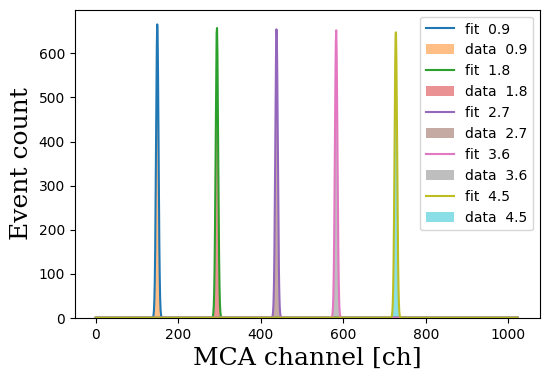

In [24]:
# @title 1.1.3. キャリブレーション用ガウシアンフィッティング

#1.1.5のプロット用変数を定義
ch = []
dch = []

pulses=np.zeros(1024)
dA=10

#プロット下地を作成
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x=np.arange(0,1024)#プロットするx軸のbinを設定
plt.xlabel('MCA channel [ch]', fontsize=18, fontfamily='serif')#x軸の名前
plt.ylabel('Event count', fontsize=18, fontfamily='serif')#y軸の名前
for hight_i,pulse_i in zip(hight,pulse_list):#入力したデータ数分繰り返し
    y=pulse_i
    dy=np.where(y > 0, np.sqrt(y), 1.0)#誤差は統計誤差の√nのみ,nが0なら0
    par_gaus, cov_gaus = curve_fit(sig, x, y, p0=(np.max(y), np.argmax(y), dA),sigma=dy)#適切な初期値を与えてフィッティング
    perr_gaus = np.sqrt(np.diag(cov_gaus))#分散共分散行列の対角成分取り出し=分散の取り出し
    #テキスト出力用成型
    mat = np.vstack((par_gaus,perr_gaus)).T
    df = pd.DataFrame(mat,index=("Constant", "Mean", "Sigma"), columns=("Estimate", "Std. error"))
    #テキスト出力
    print(df)
    #結果を記録
    ch=np.append(ch,float(par_gaus[1]))
    dch=np.append(dch,float(perr_gaus[1]))
    print("{:3.2f} {:.3f} +/- {:.3f}".format(hight_i,ch[-1],dch[-1]))
    #フィット結果のプロットを追加
    y = sig(x, *par_gaus)
    _ = ax.plot(x, y, '-', label='fit{:5.1f}'.format(hight_i))
    _ = ax.hist(x, bins=1024, weights=y, range=(0, 1025), alpha=0.5, label='data{:5.1f}'.format(hight_i))
plt.legend(loc='upper right')#凡例表示

上記でいくつかのパルス波の大きさの時にいくつかチャンネル数になるかが得られました。これを次の1.1.5.を実行することで、得られたデータ点を直線フィットします。更に1.1.6.で0 MeV相当のチャンネル数を得ます。

        Estimate    Std. error
Slope   0.006224  4.851021e-07
Offset -0.027801  2.304410e-04


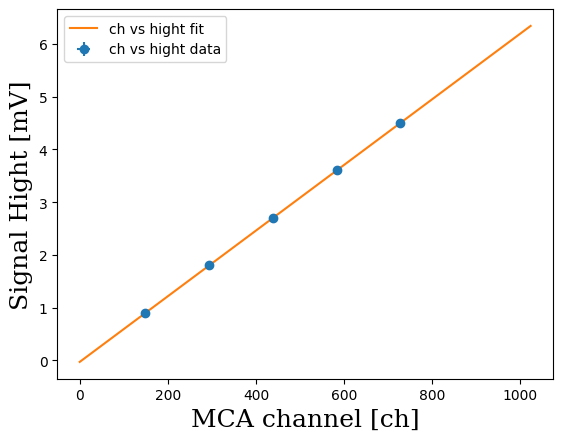

In [25]:
# @title 1.1.4. 直線フィッティング(ch vs hight)

#中心チャンネルを結ぶよう直線フィッティングして、更に0 MeV相当のチャンネル数を算出。
par_line, cov_line = curve_fit(lin, ch, hight, sigma=dch)#f(ch+/-dch)=Eを直線(lin)でフィッティング
perr_line = np.sqrt(np.diag(cov_line))#誤差抽出
#テキスト出力
mat = np.vstack((par_line,perr_line)).T
df = pd.DataFrame(mat,index=("Slope", "Offset"), columns=("Estimate", "Std. error"))
print(df)

#プロット作成
x_func = np.arange(0,1024)
y_func = par_line[0]*x_func + par_line[1]

plt.errorbar(ch,hight,0,dch,fmt="o",label='ch vs hight data')
plt.plot(x_func,y_func,label='ch vs hight fit')
plt.xlabel('MCA channel [ch]', fontsize=18, fontfamily='serif')#x軸の名前
plt.ylabel('Signal Hight [mV]', fontsize=18, fontfamily='serif')#y軸の名前
plt.legend(loc='upper left')
plt.show()

In [26]:
# @title 1.1.5. 0 MeV相当チャンネル導出
E0=(0-par_line[1])/par_line[0]#E=a*ch+b -> ch=(E-b)/aで、今E=0を求める
dE0=abs((0-par_line[1])/par_line[0]*np.sqrt((perr_line[0]/par_line[0])**2+(perr_line[1]/par_line[1])**2))#b,aにつく誤差をそれぞれ評価
print("0 MeV= {:7.2f} +/- {:7.2f} ch".format(E0,dE0))

0 MeV=    4.47 +/-    0.04 ch


続いてアルファ線が、途中標的を通過せずにセンサーに届いた場合の信号のチャンネル数を調べます。アルファ線のエネルギーが4.5 MeVであることを用いて、キャリブレーションのスケールを再決定します。
まず1.1.6.で実験データを読み込み、続けて1.1.7.及び1.1.8.を実行して、キャリブレーションが適切に行われたか確認してください。

In [25]:
# @title 1.1.6. ターゲットなし測定データ入力
#強度測定ファイル、適宜書き換えること
calib_file='60sec0degNoTarget.csv'

alpha_calib =np.genfromtxt(basePath+calib_file, skip_footer=6)
Tcalib=pathToTime(basePath+calib_file)

            Estimate  Std. error
Constant   79.466290    0.532107
Mean      799.491013    0.132556
Sigma      24.420588    0.098944


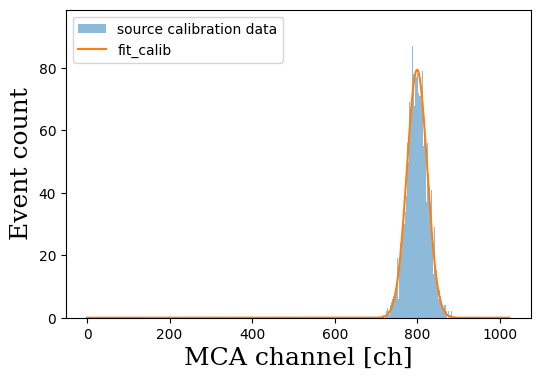

In [27]:
# @title 1.1.7. ターゲットなしデータ用ガウシアンフィッティング

#プロット下地を作成
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
_ = ax.hist(x, bins=1024, weights=alpha_calib, range=(0, 1024), alpha=0.5, label='source calibration data')#全データのヒストグラムを作成
plt.xlabel('MCA channel [ch]', fontsize=18, fontfamily='serif')#x軸の名前
plt.ylabel('Event count', fontsize=18, fontfamily='serif')#y軸の名前

dy=np.where(alpha_calib > 0, np.sqrt(alpha_calib), 1.0)#誤差は統計誤差の√nのみ,nが0なら0
par_calib, cov_calib = curve_fit(sig, x, alpha_calib, p0=(100, 800, 25), sigma=dy)#適切な初期値を与えてフィッティング
perr_calib = np.sqrt(np.diag(cov_calib))#分散共分散行列の対角成分取り出し=分散の取り出し

#テキスト出力
mat = np.vstack((par_calib,perr_calib)).T
df = pd.DataFrame(mat,index=("Constant", "Mean", "Sigma"), columns=("Estimate", "Std. error"))
print(df)

#フィット結果のプロットを追加
y = sig(x, *par_calib)
_ = ax.plot(x, y, '-', label='fit_calib')
plt.legend(loc='upper left')

4.5 MeV=  799.49 +/-    0.13 ch


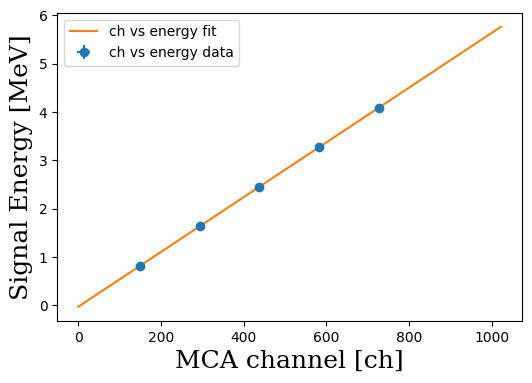

f(E4p5 [ch])= 4.500 +/- 0.001 [MeV]
f(E0 [ch])= -0.000 +/- 0.000 [MeV]


In [28]:
# @title 1.1.8. 4.5 MeV相当チャンネル導出とキャリブレーション結果確認
E4p5=par_calib[1]
dE4p5=perr_calib[1]
print("4.5 MeV= {:7.2f} +/- {:7.2f} ch".format(E4p5,dE4p5))

#4.5 MeVの高さが合うよう調整
scaling=par_line[0]*E4p5 + par_line[1]
par_line, cov_line = curve_fit(lin, ch, hight/scaling*4.5, sigma=dch)#f(ch+/-dch)=Eを直線(lin)でフィッティング
perr_line = np.sqrt(np.diag(cov_line))#誤差抽出
y = par_line[0]*x + par_line[1]

fig = plt.figure(figsize=(6, 4))
plt.errorbar(ch,hight/scaling*4.5,0,dch,fmt="o",label='ch vs energy data')
plt.plot(x,y,label='ch vs energy fit')
plt.xlabel('MCA channel [ch]', fontsize=18, fontfamily='serif')#x軸の名前
plt.ylabel('Signal Energy [MeV]', fontsize=18, fontfamily='serif')#y軸の名前
plt.legend(loc='upper left')
plt.show()

#キャリブレーションされた関数で、測定されたチャンネル数から予想されたエネルギーの値が得られるか確認
print("f(E4p5 [ch])= {:5.3f} +/- {:5.3f} [MeV]".format(lin(E4p5,par_line[0],par_line[1]),dlin(E4p5,par_line[0],par_line[1],dE4p5,perr_line[0],perr_line[1])))
print("f(E0 [ch])= {:5.3f} +/- {:5.3f} [MeV]".format(lin(E0,par_line[0],par_line[1]),dlin(E0,par_line[0],par_line[1],dE0,perr_line[0],perr_line[1])))

f(ch)の出力は誤差の範囲で意図したエネルギーを示しているでしょうか？それが確認できたら、キャリブレーションは完了です。以下ではこの関数をチャンネル数からエネルギーへの変換関数として用います。

# 1.2. 線源の強度測定

続いて1.1.でキャリブレーションに用いたデータを用いて、ターゲットに入射する信号の強度を計算します。それには、線源からセンサーへの見込み角、線源からターゲットまでの見込み角を計算する必要があり、また線源の強度を推定する必要があります。

また、のちの計算のためにターゲットからセンサーへの見込み角も計算します。

一般に見込み角は
$$
\Delta\Omega=\frac{S}{r^2}
$$
で与えられます。

テキストで与えられている実験装置のジオメトリを用いて1.2.1.から1.2.3の計算を行います。

In [29]:
# @title 1.2.1. 線源からセンサーまでの見込み角

dr2=6/2 #mm センサー手前のウィンドウ幅
S2=np.pi*dr2**2 #センサー手前のウィンドウ面積
L=130 #mm 線源からセンサーまでの距離
dOmega_RtoS=S2/L**2 #線源からセンサーまでの見込み角
print("線源からセンサーまでの見込み角={:10.3e} [sr]".format(dOmega_RtoS))

線源からセンサーまでの見込み角= 1.673e-03 [sr]


In [30]:
# @title 1.2.2. 線源からターゲットの見込み角

dr1=6/2 #mm ターゲット手前のウィンドウ幅
S1=np.pi*dr1**2 #センサー手前のウィンドウ面積
L1=58.3 #mm 線源からターゲット手前のウィンドウまでの距離
dOmega_RtoT=S1/L1**2 #線源からターゲットの見込み角
#オプション課題：ターゲット手前のウィンドウの傾きを考慮するとどうなるか検討する
print("線源からターゲットまでの見込み角={:10.3e} [sr]".format(dOmega_RtoT))

線源からターゲットまでの見込み角= 8.319e-03 [sr]


In [31]:
# @title 1.2.3. ターゲットからセンサーでの見込み角

L3=60 #mm ターゲットからセンサーまでの距離
dOmega_TtoS=S2/L3**2 #ターゲットからセンサーまでの見込み角
print("ターゲットからセンサーまでの見込み角={:10.3e} [sr]".format(dOmega_TtoS))

ターゲットから線源までの見込み角= 7.854e-03 [sr]


ここまでで計算した見込み角を用いると、線源そのものの強度と、ターゲットに入射する信号の強度が計算できます。1.2.4.,1.2.5.で計算します。

In [32]:
# @title 1.2.4. 線源強度

Ncalib=np.sum(alpha_calib)#キャリブレーションのデータ測定で得られたイベント数を全て足す

B0=Ncalib/Tcalib*4*np.pi/dOmega_RtoS#線源強度
dB0=np.sqrt(Ncalib)/Tcalib*4*np.pi/dOmega_RtoS#統計誤差
#オプション課題：不感時間を考慮するとどうなるか検討する
print("測定時間 {:.0f} [sec] 測定回数 {:8.3e} -> 線源強度={:10.3e} +/- {:7.1e} [Bq]".format(Tcalib,Ncalib,B0,dB0))


測定時間 20 [sec] 測定回数 5.000e+03 -> 線源強度= 1.878e+06 +/- 2.7e+04 [Bq]


In [33]:
# @title 1.2.5. ターゲットに入射する信号強度
B=B0*dOmega_RtoT/4/np.pi
dB=dB0*dOmega_RtoT/4/np.pi
print("ターゲットに入射する信号強度={:6.1f} +/- {:6.1f} [Bq]".format(B,dB))

ターゲットに入射する信号強度=1243.1 +/-   17.6 [Bq]


公称値2 MBqに対して測定された強度は妥当か検討してください。

# 1.3. 薄膜の厚さ測定

続いて薄膜の厚さを測定します。テキストにあるように、薄膜を通過したアルファ線のエネルギーを評価することで、厚さを計算することができます。

実験の進行状況に応じて、以下のいずれかを行ってください。

*   シミュレーションデータで行う場合: 1.3.1.を実行
*   実験データ分布を全て用いる場合: 1.3.2.を実行

続けて1.3.3.及び1.3.4を実行して、アルファ線のエネルギーを導出します。

In [144]:
# @title 1.3.2. 薄膜厚さ測定データ入力
#実データ用。ファイル名は適宜書き換えること
Aldeg0 = np.genfromtxt(basePath+'60sec0degAl.csv', skip_footer=6)
Audeg0 = np.genfromtxt(basePath+'Au.csv', skip_footer=6)

            Estimate  Std. error
Constant   39.702448    0.372352
Mean      221.178514    0.365783
Sigma      47.719240    0.277782
ch after Al: 221.2+/-  0.4
            Estimate  Std. error
Constant   79.880664    0.488818
Mean      667.313829    0.122288
Sigma      24.395617    0.088473
ch after Au: 667.3+/-  0.1


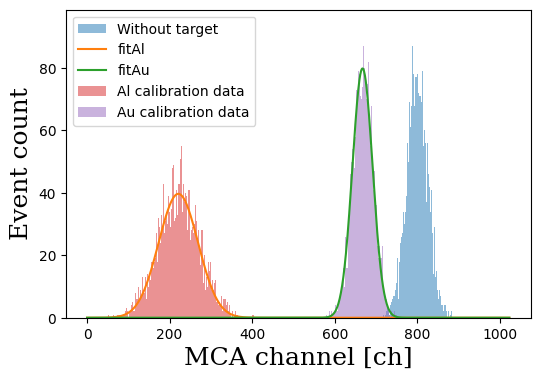

In [41]:
# @title 1.3.3. 薄膜厚さ測定用ガウシアンフィッティング

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
_ = ax.hist(x, bins=1024, weights=alpha_calib, range=(0, 1024), alpha=0.5, label='Without target')
plt.xlabel('MCA channel [ch]', fontsize=18, fontfamily='serif')#x軸の名前
plt.ylabel('Event count', fontsize=18, fontfamily='serif')#y軸の名前

#Alに関する処理
dy=np.where(Aldeg0 > 0, np.sqrt(Aldeg0), 1.0)
par_Al, cov_Al = curve_fit(sig, x, Aldeg0, p0=(np.max(Aldeg0), np.argmax(Aldeg0), 30), sigma=dy)
perr_Al = np.sqrt(np.diag(cov_Al))
mat = np.vstack((par_Al,perr_Al)).T
df = pd.DataFrame(mat,index=("Constant", "Mean", "Sigma"), columns=("Estimate", "Std. error"))
print(df)
y = sig(x, *par_Al)
_ = ax.plot(x, y, '-', label='fitAl')
print("ch after Al: {:5.1f}+/-{:5.1f}".format(par_Al[1],perr_Al[1]))#中心値とその誤差を出力

#Auに関する処理
dy=np.where(Audeg0 > 0, np.sqrt(Audeg0), 1.0)
par_Au, cov_Au = curve_fit(sig, x, Audeg0, p0=(np.max(Audeg0), np.argmax(Audeg0), 25), sigma=dy)
perr_Au = np.sqrt(np.diag(cov_Au))
mat = np.vstack((par_Au,perr_Au)).T
df = pd.DataFrame(mat,index=("Constant", "Mean", "Sigma"), columns=("Estimate", "Std. error"))
print(df)
y = sig(x, *par_Au)
_ = ax.plot(x, y, '-', label='fitAu')
print("ch after Au: {:5.1f}+/-{:5.1f}".format(par_Au[1],perr_Au[1]))#中心値とその誤差を出力

_ = ax.hist(x, bins=1024, weights=Aldeg0, range=(0, 1024), alpha=0.5, label='Al calibration data')
_ = ax.hist(x, bins=1024, weights=Audeg0, range=(0, 1024), alpha=0.5, label='Au calibration data')
plt.legend(loc='upper left')


In [42]:
# @title 1.3.4. 薄膜厚さ測定チャンネル数からエネルギーへ変換

#Alに関する変換
EAlreco=lin(par_Al[1],par_line[0],par_line[1])
dEAlreco=dlin(par_Al[1],par_line[0],par_line[1],perr_Al[1],perr_line[0],perr_line[1])
print("Al通過後のアルファ線のエネルギー : {:8.3f} +/- {:8.3f} MeV".format(EAlreco,dEAlreco))

#Auに関する変換
EAureco=lin(par_Au[1],par_line[0],par_line[1])
dEAureco=dlin(par_Au[1],par_line[0],par_line[1],perr_Au[1],perr_line[0],perr_line[1])
print("Au 通過後のアルファ線のエネルギー : {:8.3f} +/- {:8.3f} MeV".format(EAureco,dEAureco))

Al通過後のアルファ線のエネルギー :    1.227 +/-    0.002 MeV
Au 通過後のアルファ線のエネルギー :    3.752 +/-    0.001 MeV


エネルギーはテキストにある理論曲線から厚さに変換することができます。

まずは1.3.5で理論曲線をフィットし、厚さとエネルギーの関係式を求めます。

更にその関係式から各薄膜の厚さを計算します。

        Estimate  Std. error
Slope   4.542685    0.128205
Offset -2.285549    0.422323
        Estimate  Std. error
Slope   1.771394    0.038742
Offset -0.107500    0.127620


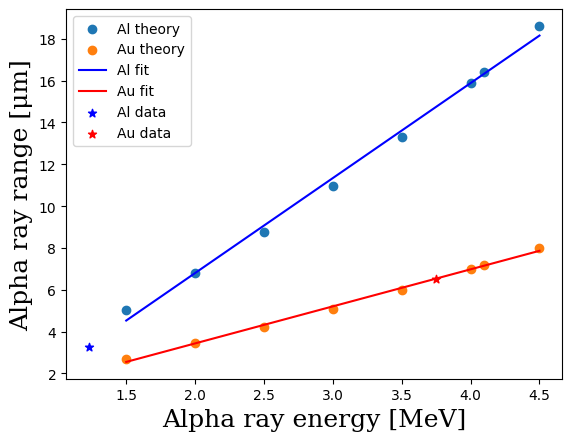

In [43]:
# @title 1.3.5.テキストにある理論値のフィッティング

#テキストにある理論値
Ealphatheo=[1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.1, 4.5]#アルファ線のエネルギー
EAltheo=[5.017, 6.804, 8.777, 10.944, 13.308, 15.867, 16.402, 18.618]#Al中の飛程
EAutheo=[2.699, 3.435, 4.230, 5.086, 6.002, 6.974, 7.175, 8.001]#Au中の飛程

#Alに関するフィッティング
par_Al_line, cov_Al_line = curve_fit(lin, Ealphatheo, EAltheo)#アルファ線のエネルギー[MeV]->アルファ線が飛べるAlの厚さ[um]の式をフィッティング
perr_Al_line = np.sqrt(np.diag(cov_Al_line))
mat = np.vstack((par_Al_line,perr_Al_line)).T
df = pd.DataFrame(mat,index=("Slope", "Offset"), columns=("Estimate", "Std. error"))
print(df)

#Auに関するフィッティング
par_Au_line, cov_Au_line = curve_fit(lin, Ealphatheo, EAutheo)#アルファ線のエネルギー[MeV]->アルファ線が飛べるAlの厚さ[um]の式をフィッティング
perr_Au_line = np.sqrt(np.diag(cov_Au_line))
mat = np.vstack((par_Au_line,perr_Au_line)).T
df = pd.DataFrame(mat,index=("Slope", "Offset"), columns=("Estimate", "Std. error"))
print(df)

#プロット
plt.scatter(Ealphatheo,EAltheo,marker="o",label='Al theory')#理論値Al
plt.scatter(Ealphatheo,EAutheo,marker="o",label='Au theory')#理論値Au
plt.xlabel('Alpha ray energy [MeV]', fontsize=18, fontfamily='serif')#x軸の名前
plt.ylabel('Alpha ray range [μm]', fontsize=18, fontfamily='serif')#y軸の名前
x_func = np.arange(1.5,5.5)
y_funcAl = par_Al_line[0]*x_func + par_Al_line[1]
y_funcAu = par_Au_line[0]*x_func + par_Au_line[1]
plt.plot(x_func,y_funcAl,'b',label='Al fit')
plt.plot(x_func,y_funcAu,'r',label='Au fit')
plt.scatter(EAlreco,par_Al_line[0]*EAlreco+par_Al_line[1],marker="*",color='b',label='Al data')#測定値Al
plt.scatter(EAureco,par_Au_line[0]*EAureco+par_Au_line[1],marker="*",color='r',label='Au data')#測定値Au
plt.legend(loc='upper left')


In [44]:
# @title 1.3.6.エネルギーから厚さへの変換

#厚さとエネルギーの関係式から、Al薄膜の厚さを求める
RAl=lin(EAlreco,par_Al_line[0],par_Al_line[1])#測定された、残りのエネルギーで飛べるAlの厚さ
dRAl=dlin(EAlreco,par_Al_line[0],par_Al_line[1],dEAlreco,perr_Al_line[0],perr_Al_line[1])#その誤差
dxAl=18.618-RAl#アルファ線が飛んできたAlの厚さ
print("Al残り飛程: {:10.2f} +/- {:10.2f} [um] -> 厚さdx={:10.2f} +/- {:10.2f} [um]".format(RAl,dRAl,dxAl,dRAl))

#以下Auに関して同様
RAu=lin(EAureco,par_Au_line[0],par_Au_line[1])
dRAu=dlin(EAureco,par_Au_line[0],par_Au_line[1],dEAureco,perr_Au_line[0],perr_Au_line[1])
dxAu=8.001-RAu
print("Au残り飛程: {:10.2f} +/- {:10.2f} [um] -> 厚さdx={:10.2f} +/- {:10.2f} [um]".format(RAu,dRAu,dxAu,dRAu))

Al残り飛程:       3.29 +/-       0.45 [um] -> 厚さdx=     15.33 +/-       0.45 [um]
Au残り飛程:       6.54 +/-       0.19 [um] -> 厚さdx=      1.46 +/-       0.19 [um]


求められた厚さを公称値と比較してください。

以上で装置のキャリブレーション・測定が完了しました。

# 2.測定値の推定

1.で得られた値を基に、大角度の散乱現象の測定計画を立てます。

まずは2.1.1.を実行して測定・計算された値を振り返りましょう。また厚さの値を用いて2.1.2.で単位面積当たりの原子数を計算しましょう。

In [45]:
# @title 2.1.1.測定・計算された値の振り返り
print("ターゲットに入射する信号強度={:6.1f} +/- {:6.1f} [Bq]".format(B,dB))
print("ターゲットから線源までの見込み角={:10.3e} [sr]".format(dOmega_TtoS))
print("Al厚さdx={:10.2f} +/- {:10.2f} [um]".format(dxAl,dRAl))
print("Au厚さdx={:10.2f} +/- {:10.2f} [um]".format(dxAu,dRAu))
print("キャリブレーションを行った時間={:4.0f}[sec]".format(Tcalib))

ターゲットに入射する信号強度=1243.1 +/-   17.6 [Bq]
ターゲットから線源までの見込み角= 7.854e-03 [sr]
Al厚さdx=     15.33 +/-       0.45 [um]
Au厚さdx=      1.46 +/-       0.19 [um]
キャリブレーションを行った時間=  20[sec]


In [46]:
# @title 2.1.2.原子密度の計算
#計算用パラメタ
NA=6.02e23
Al_weight=26.98
Au_weight=196.97
#Al密度計算
NAl=dxAl*1e-4*2.69*NA/Al_weight #dxAl[cm]*2.69[g/cm^3]*NA[count/mol]/weight[g/mol]
dNAl=dRAl*1e-4*2.69*NA/Al_weight
print("単位面積当たりアルミニウム原子数={:10.1e} [1/cm^2]={:10.1e} [1/fm^2]".format(NAl,NAl*1e-26))
#Au密度計算
NAu=dxAu*1e-4*19.3*NA/Au_weight
dNAu=dRAu*1e-4*19.3*NA/Au_weight
print("単位面積当たり金原子数={:10.1e} [1/cm^2]={:10.1e} [1/fm^2]".format(NAu,NAu*1e-26))
print("")

単位面積当たりアルミニウム原子数=   9.2e+19 [1/cm^2]=   9.2e-07 [1/fm^2]
単位面積当たり金原子数=   8.6e+18 [1/cm^2]=   8.6e-08 [1/fm^2]



続いて2.1.3.で仮に実験計画のパラメタ設定をしてから、2.1.4.で各薄膜で散乱現象が起こる確率
$$
\frac{dσ}{d\Omega}(θ,ϕ)=(\frac{zZe^2}{4E_{α}})^2\frac{1}{\sin^4(θ/2)}
$$
を計算します。

In [47]:
# @title 2.1.3.測定計画パラメタの設定
theta=50
t=3*24*60*60#sec
print("測定時間{:10.0f}秒={:10.0f}分".format(t,t/60))

測定時間    259200秒=      4320分


dsigma/dOmega(Al)=   1.4e+02[fm^2/sr]
dsigma/dOmega(Au)=   5.0e+03[fm^2/sr]


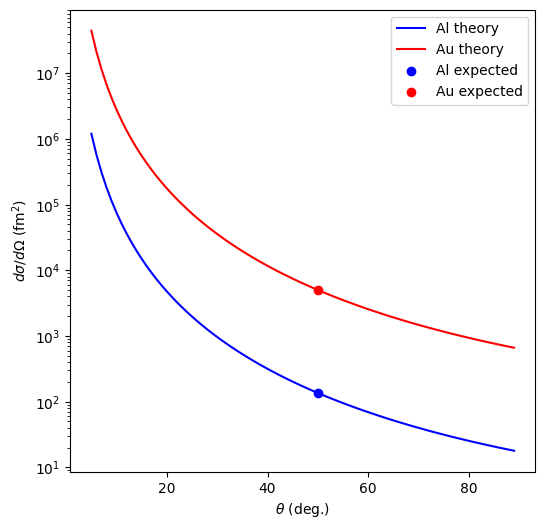

In [48]:
# @title 2.1.4.散乱確率の見積もり
#計算用パラメタ
z = 2  # alpha は4He 2+
ZAl = 13  # Alの陽子数は13
ZAu = 79  # Auの陽子数は79
hbarc = 197.3
alpha = 1/137.
e2 = hbarc*alpha
E = 4.5

#Al散乱確率計算
AAl = (z*ZAl*e2/4/E)**2
dsigmadOmegaAl=AAl*(np.sin(np.radians(theta)/2))**-4
print("dsigma/dOmega(Al)={:10.1e}[fm^2/sr]".format(dsigmadOmegaAl))

#Au散乱確率計算
AAu = (z*ZAu*e2/4/E)**2
dsigmadOmegaAu=AAu*(np.sin(np.radians(theta)/2))**-4
print("dsigma/dOmega(Au)={:10.1e}[fm^2/sr]".format(dsigmadOmegaAu))

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
x=np.arange(5,90)#プロットするx軸のbinを設定
fAl=AAl*(np.sin(np.radians(x)/2))**-4
fAu=AAu*(np.sin(np.radians(x)/2))**-4
ax.plot(x, fAl, 'b-',label='Al theory')
ax.plot(x, fAu, 'r-',label='Au theory')
plt.scatter(theta,dsigmadOmegaAl,marker="o",color="b",label='Al expected')#理論値Al
plt.scatter(theta,dsigmadOmegaAu,marker="o",color="r",label='Au expected')#理論値Al
plt.yscale('log')  # ログスケール
ax.set_xlabel(r'$\theta$ (deg.)')
ax.set_ylabel(r'$d\sigma/d\Omega$ (fm$^2$)')
plt.legend(loc='upper right')

値は全て揃いました。0.で与えた関係式を用いて、予想される信号数を2.1.5.で計算します。

In [49]:
# @title 2.1.5.散乱事象観測数の見積もり
N_expectedAl=B*t*NAl*1e-26*dsigmadOmegaAl*dOmega_TtoS
dN_expectedAl=B*t*NAl*1e-26*dsigmadOmegaAl*dOmega_TtoS*np.sqrt((dB/B)**2+(1/np.sqrt(NAl)**2)+(dNAl/NAl)**2)
print("推定測定回数(Al)={:10.1e}+/-{:10.1e}".format(N_expectedAl,dN_expectedAl))
N_expectedAu=B*t*NAu*1e-26*dsigmadOmegaAu*dOmega_TtoS
dN_expectedAu=B*t*NAu*1e-26*dsigmadOmegaAu*dOmega_TtoS*np.sqrt((dB/B)**2+(1/np.sqrt(NAu)**2)+(dNAu/NAu)**2)
print("推定測定回数(Au)={:10.1e}+/-{:10.1e}".format(N_expectedAu,dN_expectedAu))

推定測定回数(Al)=   3.2e+02+/-   1.0e+01
推定測定回数(Au)=   1.1e+03+/-   1.5e+02


推定された値はラザフォード散乱を"発見"するうえで十分だといえるでしょうか？2.1.3のパラメタを変更して様々なケースの推定を行ってみましょう。

オプション課題:小角度散乱の場合は多くの事象が期待されます。短時間の測定回数を高精度で予測できるでしょうか？寄与の大きな誤差は？